In [1]:
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.nn import functional as func
import matplotlib.pyplot as plt

from tqdm import tqdm
import os, sys
import random
import numpy as np

import util
from model import RecurrentAE
from args import get_train_args

%load_ext autoreload
%autoreload 2

In [2]:
def LoG(img):
    weight = [
        [0, 0, 1, 0, 0],
        [0, 1, 2, 1, 0],
        [1, 2, -16, 2, 1],
        [0, 1, 2, 1, 0],
        [0, 0, 1, 0, 0]
    ]
    weight = np.array(weight)

    weight_np = np.zeros((1, 1, 5, 5))
    weight_np[0, 0, :, :] = weight
    weight_np = np.repeat(weight_np, img.shape[1], axis=1)
    weight_np = np.repeat(weight_np, img.shape[0], axis=0)

    weight = torch.from_numpy(weight_np).type(torch.FloatTensor).to('cuda:0')

    return func.conv2d(img, weight, padding=1)

def HFEN(output, target):
    return torch.sum(torch.pow(LoG(output) - LoG(target), 2)) / torch.sum(torch.pow(LoG(target), 2))


def l1_norm(output, target):
    return torch.sum(torch.abs(output - target)) / torch.numel(output)


In [3]:
def loss_fn(recon_x, x, mu, logvar):
#     BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    BCE = 0.875 * l1_norm(recon_x, x) + 0.125 * HFEN(recon_x, x)
    # BCE = F.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

#     return BCE + KLD, BCE, KLD
    return BCE + KLD, BCE, KLD

def loss_fn_rae(output, target):
    ls = util.l1_norm(output, target)
    lg = util.HFEN(output, target)
    return 0.875 * ls + 0.125 * lg, ls, lg

In [4]:
args = get_train_args()

args.save_dir = args.save_dir + "train/" + args.name + "/"
if not os.path.exists(args.save_dir):
    os.makedirs(args.save_dir)

log = util.get_logger(args.save_dir, args.name)
device, gpu_ids = util.get_available_devices()
print(device)

# Set random seed
log.info('Using random seed {}...'.format(args.seed))
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)


cuda:0
[03.20.19 13:51:26] Using random seed 248...


In [5]:
# Get model
log.info('Building model...')
model = RecurrentAE(input_nc=3, device=device)
model = model.to(device)
model.train()

optimizer = optim.Adam(model.parameters(), lr=args.lr) 
# optimizer = optim.Adam(model.parameters(), lr=args.lr, betas=(0.9, 0.99)) 

[03.20.19 13:51:29] Building model...


In [6]:
# Add salt and pepper noise
def sap(img): 
    h,w = img.size 
    imgp = img.load()
    i = h * w // 40
    rd = random.sample(range(0,h*w), i) 
    rd_h = [num // w for num in rd] 
    rd_w = [num % w for num in rd] 
    for idx in range(i): 
        sap = int(random.randint(0,1) * 255) 
        imgp[rd_h[idx],rd_w[idx]] = (sap,sap,sap)
    
    return img

In [7]:
# from PIL import Image

# test_img = Image.open("dataset/train/ori/rand_0002.png")
# # sap(test_img)
# sap_transform = transforms.Lambda(sap)
# sap_transform(test_img)
# test_img.show()

In [14]:
# Get data loader
log.info('Building dataset...')
train_dataset = util.DLSSDataset(root_dir=args.train_dataset_dir,
                                 transform=transforms.Compose([
                                    # Add salt and pepper noise
#                                     transforms.Lambda(sap),
                                    transforms.CenterCrop(256),
                                    transforms.ToTensor()
                                 ])
                                 ,train_transform=transforms.Lambda(sap)
                                )   
train_loader = data.DataLoader(train_dataset,
                               batch_size=args.batch_size,
                               shuffle=True)

dev_dataset = util.DLSSDataset(root_dir=args.dev_dataset_dir,
                               transform=transforms. \
                                   Compose([
                                   transforms.CenterCrop(256),
                                   transforms.ToTensor()
                               ]))    
dev_loader = data.DataLoader(dev_dataset,
                             batch_size=args.batch_size,
                             shuffle=False)


[03.20.19 13:52:52] Building dataset...


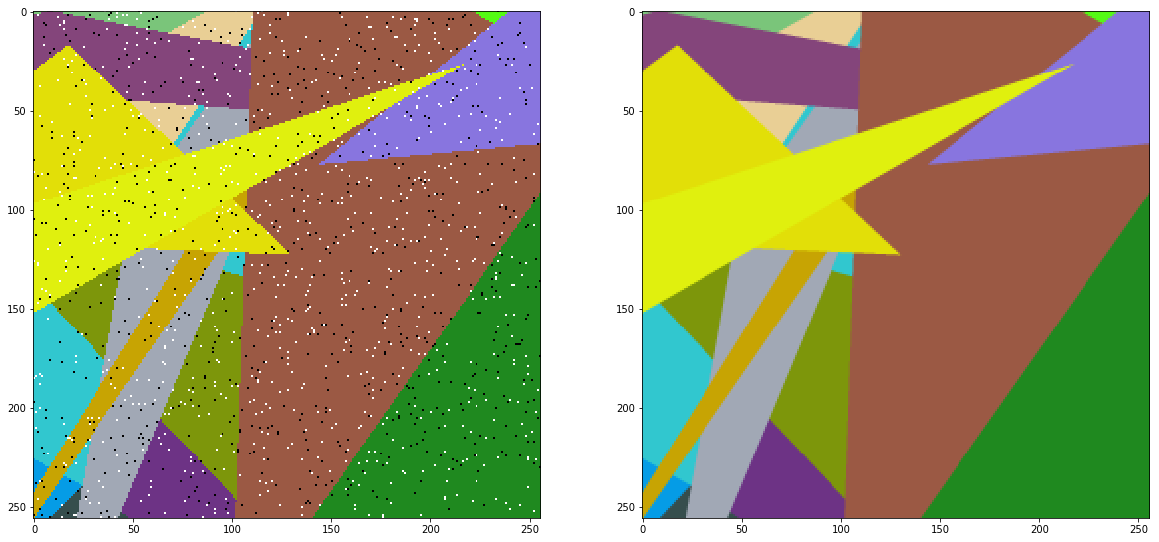

In [15]:
pil2tensor = transforms.ToTensor()
tensor2pil = transforms.ToPILImage()

# idx = random.randint(0, len(train_dataset))
idx = 2
ori_t, ss_t = train_dataset[idx]
ori_i, ss_i = tensor2pil(ori_t), tensor2pil(ss_t)
# print(train_dataset[0])
%matplotlib inline
plt.figure(figsize = (20,20))
plt.subplot(1,2,1)
plt.imshow(np.asarray(ori_i))
plt.subplot(1,2,2)
plt.imshow(np.asarray(ss_i))

In [10]:
print(len(train_dataset))
# print(train_loader.dataset[0])

1790


In [11]:
# # Train vae
# log.info('Training')
# step = 0
# epoch = 0
# batch_size = args.batch_size
# model.train()
# while epoch != args.num_epochs:
#     epoch += 1
# #     log.info('Starting epoch {}...'.format(epoch))

#     with torch.enable_grad(), \
#             tqdm(total=len(train_loader.dataset)) as progress_bar:
#         for ori, ss in train_loader:
#             ori = ori.to(device)
#             ss = ss.to(device)
#             model = model.to(device)

#             output, mu, logvar = model(ori)
#             mu = mu.to(device)
#             logvar = logvar.to(device)
#             loss, bce, kld = loss_fn(output, ss, mu, logvar)
# #             loss, bce, kld = loss_fn(output, dist, mu, logvar)
#             loss_val = loss.item()
#             optimizer.zero_grad()
#             loss.backward()
# #             nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)
#             optimizer.step()

#             step += batch_size
#             progress_bar.update(batch_size)
#             progress_bar.set_postfix(epoch=epoch, CE=loss_val)

In [13]:
# Train rae
log.info('Training')
step = 0
epoch = 0
best_dev_loss = 1e9
batch_size = args.batch_size
dev_sv_idx = random.randint(0,batch_size-1)
model.train()
while epoch != args.num_epochs:
    epoch += 1
#     log.info('Starting epoch {}...'.format(epoch))

    with torch.enable_grad(), \
            tqdm(total=len(train_loader.dataset)) as progress_bar:
        for ori, ss in train_loader:
            ori = ori.to(device)
            ss = ss.to(device)
            model = model.to(device)
            model.set_input(ori)
            model.reset_hidden()

            output = model()
            loss, ls, lg = loss_fn_rae(output, ss)
            loss_val = loss.item()
            optimizer.zero_grad()
            loss.backward()
            # nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)
            optimizer.step()

            step += batch_size
            progress_bar.update(batch_size)
            progress_bar.set_postfix(epoch=epoch, Loss=loss_val)

    # Evaluate every epoch and save the best model
    model.eval()
    total_loss_val = 0
    for ori_dev, ss_dev in dev_loader:
        ori_dev = ori_dev.to(device)
        ss_dev = ss_dev.to(device)
        model = model.to(device)
        model.set_input(ori_dev)
        model.reset_hidden()

        output_dev = model()
        loss, ls, lg = loss_fn_rae(output_dev, ss_dev)
        total_loss_val += loss.item()
    if total_loss_val < best_dev_loss:
        best_dev_loss = total_loss_val
        torch.save(model.state_dict(), "best_rae.pt")
        log.info("Better model saved. Average loss: " + str(total_loss_val/len(dev_loader)))
        # Save the new better dev image
        plt.imsave("dev_png/epoch_{}.png".format(epoch), np.asarray(tensor2pil(output_dev[dev_sv_idx].cpu().detach())))

    if epoch == 1:
        plt.imsave("dev_png/origin.png", np.asarray(tensor2pil(ori_dev[dev_sv_idx].cpu().detach())))
        plt.imsave("dev_png/ss.png", np.asarray(tensor2pil(ss_dev[dev_sv_idx].cpu().detach())))
    
    model.train()

  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 20:20:09] Training


/home/jack/anaconda3/lib/python3.7/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
1792it [00:47, 40.85it/s, Loss=0.257, epoch=1]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 20:21:05] Better model saved. Average loss: 0.23923156280070543


1792it [00:47, 39.75it/s, Loss=0.217, epoch=2]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 20:22:01] Better model saved. Average loss: 0.21243545040488243


1792it [00:47, 41.24it/s, Loss=0.239, epoch=3]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 20:22:57] Better model saved. Average loss: 0.20357861928641796


1792it [00:47, 42.16it/s, Loss=0.163, epoch=4]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 20:23:53] Better model saved. Average loss: 0.15537250135093927


1792it [00:46, 41.41it/s, Loss=0.142, epoch=5]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 20:24:48] Better model saved. Average loss: 0.13457714300602674


1792it [00:47, 41.50it/s, Loss=0.133, epoch=6]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 20:25:44] Better model saved. Average loss: 0.1295355837792158


1792it [00:47, 41.47it/s, Loss=0.135, epoch=7]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 20:26:40] Better model saved. Average loss: 0.12633103309199215


1792it [00:46, 41.70it/s, Loss=0.126, epoch=8]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 20:27:35] Better model saved. Average loss: 0.12124285763129591


1792it [00:47, 39.25it/s, Loss=0.126, epoch=9]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 20:28:32] Better model saved. Average loss: 0.11612657541409135


1792it [00:46, 37.32it/s, Loss=0.122, epoch=10]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 20:29:27] Better model saved. Average loss: 0.11277475617825986


1792it [00:46, 41.46it/s, Loss=0.12, epoch=11]                           
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 20:30:23] Better model saved. Average loss: 0.11252254452556372


1792it [00:46, 41.57it/s, Loss=0.11, epoch=12]                           
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 20:31:18] Better model saved. Average loss: 0.10466327108442783


1792it [00:47, 41.99it/s, Loss=0.106, epoch=13]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 20:32:14] Better model saved. Average loss: 0.09893222823739052


1792it [00:47, 41.93it/s, Loss=0.103, epoch=14]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 20:33:09] Better model saved. Average loss: 0.09333314504474402


1792it [00:47, 40.77it/s, Loss=0.0967, epoch=15]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 20:34:05] Better model saved. Average loss: 0.08959039291366935


1792it [00:47, 40.30it/s, Loss=0.0962, epoch=16]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 20:35:02] Better model saved. Average loss: 0.08652674062177539


1792it [00:46, 41.62it/s, Loss=0.0914, epoch=17]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 20:35:57] Better model saved. Average loss: 0.08367887018248439


1792it [00:47, 42.27it/s, Loss=0.0874, epoch=18]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 20:36:53] Better model saved. Average loss: 0.079375702701509


1792it [00:47, 41.90it/s, Loss=0.0838, epoch=19]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 20:37:49] Better model saved. Average loss: 0.07710762834176421


1792it [00:46, 41.66it/s, Loss=0.085, epoch=20]                           
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 20:38:44] Better model saved. Average loss: 0.07582869669422507


1792it [00:47, 41.53it/s, Loss=0.0782, epoch=21]                          
1792it [00:46, 41.60it/s, Loss=0.0817, epoch=22]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 20:40:35] Better model saved. Average loss: 0.07147688092663884


1792it [00:47, 41.31it/s, Loss=0.0765, epoch=23]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 20:41:31] Better model saved. Average loss: 0.06901065474376082


1792it [00:48, 41.77it/s, Loss=0.0746, epoch=24]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 20:42:28] Better model saved. Average loss: 0.06774599850177765


1792it [00:47, 41.26it/s, Loss=0.077, epoch=25]                           
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 20:43:24] Better model saved. Average loss: 0.0669982681516558


1792it [00:46, 41.49it/s, Loss=0.0764, epoch=26]                          
1792it [00:46, 41.39it/s, Loss=0.0742, epoch=27]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 20:45:14] Better model saved. Average loss: 0.06458956156857312


1792it [00:47, 41.18it/s, Loss=0.072, epoch=28]                           
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 20:46:11] Better model saved. Average loss: 0.06186927487142384


1792it [00:47, 41.84it/s, Loss=0.0709, epoch=29]                          
1792it [00:47, 41.88it/s, Loss=0.0702, epoch=30]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 20:48:02] Better model saved. Average loss: 0.059295470686629416


1792it [00:47, 38.11it/s, Loss=0.0673, epoch=31]                          
1792it [00:50, 38.35it/s, Loss=0.0664, epoch=32]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 20:49:58] Better model saved. Average loss: 0.05802818415686488


1792it [00:47, 41.94it/s, Loss=0.0642, epoch=33]                          
1792it [00:46, 41.38it/s, Loss=0.0657, epoch=34]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 20:51:50] Better model saved. Average loss: 0.05752834226004779


1792it [00:49, 34.49it/s, Loss=0.0635, epoch=35]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 20:52:49] Better model saved. Average loss: 0.05558847151696682


1792it [00:47, 41.13it/s, Loss=0.0628, epoch=36]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 20:53:45] Better model saved. Average loss: 0.05526039735414088


1792it [00:46, 42.13it/s, Loss=0.0646, epoch=37]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 20:54:40] Better model saved. Average loss: 0.05508824978023767


1792it [00:45, 42.23it/s, Loss=0.0631, epoch=38]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 20:55:34] Better model saved. Average loss: 0.05375205301679671


1792it [00:46, 42.17it/s, Loss=0.0655, epoch=39]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 20:56:29] Better model saved. Average loss: 0.052917709853500125


1792it [00:45, 40.70it/s, Loss=0.0643, epoch=40]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 20:57:24] Better model saved. Average loss: 0.05257785962894559


1792it [00:47, 41.86it/s, Loss=0.0631, epoch=41]                          
1792it [00:46, 41.55it/s, Loss=0.0594, epoch=42]                          
1792it [00:45, 42.58it/s, Loss=0.0589, epoch=43]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 21:00:09] Better model saved. Average loss: 0.0520170081872493


1792it [00:45, 42.05it/s, Loss=0.0586, epoch=44]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 21:01:03] Better model saved. Average loss: 0.05040223831310868


1792it [00:48, 41.87it/s, Loss=0.0589, epoch=45]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 21:02:00] Better model saved. Average loss: 0.05019584936089814


1792it [00:46, 41.84it/s, Loss=0.0602, epoch=46]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 21:02:55] Better model saved. Average loss: 0.049534379364922644


1792it [00:46, 41.90it/s, Loss=0.0581, epoch=47]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 21:03:50] Better model saved. Average loss: 0.04868936254642904


1792it [00:47, 41.01it/s, Loss=0.0571, epoch=48]                          
1792it [00:46, 42.26it/s, Loss=0.0593, epoch=49]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 21:05:41] Better model saved. Average loss: 0.04835549648851156


1792it [00:47, 40.31it/s, Loss=0.0549, epoch=50]                          
1792it [00:46, 42.19it/s, Loss=0.0534, epoch=51]                          
1792it [00:45, 39.69it/s, Loss=0.0545, epoch=52]                          
1792it [00:49, 40.77it/s, Loss=0.059, epoch=53]                           
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 21:09:26] Better model saved. Average loss: 0.04767448171041906


1792it [00:46, 41.08it/s, Loss=0.0597, epoch=54]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 21:10:21] Better model saved. Average loss: 0.04706618096679449


1792it [00:46, 39.45it/s, Loss=0.0604, epoch=55]                          
1792it [00:47, 39.31it/s, Loss=0.0505, epoch=56]                          
1792it [00:46, 37.63it/s, Loss=0.0576, epoch=57]                          
1792it [00:46, 41.71it/s, Loss=0.0523, epoch=58]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 21:14:02] Better model saved. Average loss: 0.046251993253827096


1792it [00:46, 41.94it/s, Loss=0.0546, epoch=59]                          
1792it [00:46, 42.05it/s, Loss=0.053, epoch=60]                           
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 21:15:52] Better model saved. Average loss: 0.0457556139677763


1792it [00:46, 42.24it/s, Loss=0.0536, epoch=61]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 21:16:47] Better model saved. Average loss: 0.045723491720855235


1792it [00:46, 38.04it/s, Loss=0.0539, epoch=62]                          
1792it [00:46, 42.01it/s, Loss=0.0492, epoch=63]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 21:18:37] Better model saved. Average loss: 0.04459233111701906


1792it [00:46, 42.04it/s, Loss=0.0535, epoch=64]                          
1792it [00:46, 41.65it/s, Loss=0.0497, epoch=65]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 21:20:27] Better model saved. Average loss: 0.044117673113942144


1792it [00:46, 42.03it/s, Loss=0.0535, epoch=66]                          
1792it [00:46, 39.40it/s, Loss=0.0482, epoch=67]                          
1792it [00:47, 41.81it/s, Loss=0.0537, epoch=68]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 21:23:12] Better model saved. Average loss: 0.04347558529116213


1792it [00:46, 42.06it/s, Loss=0.0528, epoch=69]                          
1792it [00:46, 42.67it/s, Loss=0.0486, epoch=70]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 21:25:02] Better model saved. Average loss: 0.04269646969623864


1792it [00:46, 41.90it/s, Loss=0.0491, epoch=71]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 21:25:56] Better model saved. Average loss: 0.04250770546495915


1792it [00:46, 41.45it/s, Loss=0.0481, epoch=72]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 21:26:52] Better model saved. Average loss: 0.042174744652584195


1792it [00:46, 41.78it/s, Loss=0.0503, epoch=73]                          
1792it [00:46, 42.07it/s, Loss=0.0482, epoch=74]                          
1792it [00:46, 42.00it/s, Loss=0.0496, epoch=75]                          
1792it [00:46, 40.67it/s, Loss=0.0462, epoch=76]                          
1792it [00:47, 39.06it/s, Loss=0.0513, epoch=77]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 21:31:28] Better model saved. Average loss: 0.04131429921835661


1792it [00:46, 41.66it/s, Loss=0.0496, epoch=78]                          
1792it [00:46, 41.82it/s, Loss=0.0528, epoch=79]                          
1792it [00:46, 41.98it/s, Loss=0.0482, epoch=80]                          
1792it [00:46, 41.91it/s, Loss=0.0459, epoch=81]                          
1792it [00:46, 41.98it/s, Loss=0.0507, epoch=82]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 21:36:03] Better model saved. Average loss: 0.041183133330196145


1792it [00:47, 41.30it/s, Loss=0.0516, epoch=83]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 21:36:59] Better model saved. Average loss: 0.04087132061831653


1792it [00:47, 41.30it/s, Loss=0.0458, epoch=84]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 21:37:55] Better model saved. Average loss: 0.040726291062310335


1792it [00:47, 35.34it/s, Loss=0.0445, epoch=85]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 21:38:52] Better model saved. Average loss: 0.04002920300699771


1792it [00:48, 37.99it/s, Loss=0.0483, epoch=86]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 21:39:50] Better model saved. Average loss: 0.0394084217492491


1792it [00:47, 41.09it/s, Loss=0.0497, epoch=87]                          
1792it [00:48, 38.56it/s, Loss=0.0476, epoch=88]                          
1792it [00:48, 40.16it/s, Loss=0.0505, epoch=89]                          
1792it [00:48, 41.99it/s, Loss=0.046, epoch=90]                           
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 21:43:39] Better model saved. Average loss: 0.038861091062426564


1792it [00:46, 41.58it/s, Loss=0.0461, epoch=91]                          
1792it [00:46, 41.80it/s, Loss=0.0437, epoch=92]                          
1792it [00:46, 41.76it/s, Loss=0.0466, epoch=93]                          
1792it [00:46, 41.79it/s, Loss=0.0461, epoch=94]                          
1792it [00:46, 41.91it/s, Loss=0.0437, epoch=95]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 21:48:14] Better model saved. Average loss: 0.0384694657754153


1792it [00:46, 41.73it/s, Loss=0.0428, epoch=96]                          
1792it [00:46, 42.21it/s, Loss=0.0448, epoch=97]                          
1792it [00:46, 41.86it/s, Loss=0.0435, epoch=98]                          
1792it [00:47, 42.05it/s, Loss=0.0455, epoch=99]                          
1792it [00:46, 41.86it/s, Loss=0.0424, epoch=100]                          
1792it [00:46, 39.76it/s, Loss=0.0433, epoch=101]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 21:53:44] Better model saved. Average loss: 0.03817618717439473


1792it [00:47, 41.65it/s, Loss=0.048, epoch=102]                           
1792it [00:46, 41.63it/s, Loss=0.0479, epoch=103]                          
1792it [00:47, 42.13it/s, Loss=0.0442, epoch=104]                          
1792it [00:47, 41.51it/s, Loss=0.0397, epoch=105]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 21:57:27] Better model saved. Average loss: 0.037472418928518894


1792it [00:48, 41.51it/s, Loss=0.0473, epoch=106]                          
1792it [00:46, 41.61it/s, Loss=0.0389, epoch=107]                          
1792it [00:47, 41.51it/s, Loss=0.0451, epoch=108]                          
1792it [00:47, 41.99it/s, Loss=0.0432, epoch=109]                          
1792it [00:46, 42.18it/s, Loss=0.041, epoch=110]                           
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 22:02:06] Better model saved. Average loss: 0.03686317643150687


1792it [00:47, 41.47it/s, Loss=0.04, epoch=111]                            
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 22:03:02] Better model saved. Average loss: 0.036822915496304634


1792it [00:46, 42.26it/s, Loss=0.043, epoch=112]                           
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 22:03:56] Better model saved. Average loss: 0.03660691045224666


1792it [00:46, 41.69it/s, Loss=0.0423, epoch=113]                          
1792it [00:46, 39.41it/s, Loss=0.0421, epoch=114]                          
1792it [00:49, 41.68it/s, Loss=0.0411, epoch=115]                          
1792it [00:46, 42.32it/s, Loss=0.0438, epoch=116]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 22:07:39] Better model saved. Average loss: 0.0361731244251132


1792it [00:46, 38.47it/s, Loss=0.0418, epoch=117]                          
1792it [00:46, 39.29it/s, Loss=0.0406, epoch=118]                          
1792it [00:46, 41.65it/s, Loss=0.0451, epoch=119]                          
1792it [00:46, 41.58it/s, Loss=0.0426, epoch=120]                          
1792it [00:47, 41.58it/s, Loss=0.0374, epoch=121]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 22:12:14] Better model saved. Average loss: 0.03607955793850124


1792it [00:47, 42.29it/s, Loss=0.0399, epoch=122]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 22:13:10] Better model saved. Average loss: 0.035865929117426275


1792it [00:46, 41.92it/s, Loss=0.0407, epoch=123]                          
1792it [00:45, 36.67it/s, Loss=0.0437, epoch=124]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 22:15:00] Better model saved. Average loss: 0.0355524277780205


1792it [00:46, 41.99it/s, Loss=0.0418, epoch=125]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 22:15:55] Better model saved. Average loss: 0.03494414046872407


1792it [00:47, 41.81it/s, Loss=0.0388, epoch=126]                          
1792it [00:46, 41.58it/s, Loss=0.0378, epoch=127]                          
1792it [00:47, 38.54it/s, Loss=0.0417, epoch=128]                          
1792it [00:46, 38.66it/s, Loss=0.0429, epoch=129]                          
1792it [00:47, 41.00it/s, Loss=0.0376, epoch=130]                          
1792it [00:47, 36.62it/s, Loss=0.0398, epoch=131]                          
1792it [00:47, 35.90it/s, Loss=0.0381, epoch=132]                          
1792it [00:46, 42.00it/s, Loss=0.0451, epoch=133]                          
1792it [00:46, 41.12it/s, Loss=0.039, epoch=134]                           
1792it [00:46, 41.58it/s, Loss=0.0418, epoch=135]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 22:25:12] Better model saved. Average loss: 0.034263549093157056


1792it [00:46, 42.11it/s, Loss=0.0361, epoch=136]                          
1792it [00:47, 40.76it/s, Loss=0.0383, epoch=137]                          
1792it [00:47, 40.20it/s, Loss=0.0378, epoch=138]                          
1792it [00:47, 41.86it/s, Loss=0.0419, epoch=139]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 22:28:53] Better model saved. Average loss: 0.03374629383906722


1792it [00:46, 41.55it/s, Loss=0.0353, epoch=140]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 22:29:49] Better model saved. Average loss: 0.03366895855870098


1792it [00:46, 41.39it/s, Loss=0.0403, epoch=141]                          
1792it [00:46, 41.50it/s, Loss=0.0376, epoch=142]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 22:31:39] Better model saved. Average loss: 0.03339470105711371


1792it [00:46, 36.31it/s, Loss=0.0406, epoch=143]                          
1792it [00:47, 41.93it/s, Loss=0.0344, epoch=144]                          
1792it [00:46, 40.72it/s, Loss=0.0372, epoch=145]                          
1792it [00:47, 41.51it/s, Loss=0.0332, epoch=146]                          
1792it [00:46, 41.73it/s, Loss=0.036, epoch=147]                           
1792it [00:47, 41.63it/s, Loss=0.0357, epoch=148]                          
  0%|          | 0/1790 [00:00<?, ?it/s]

[03.11.19 22:37:13] Better model saved. Average loss: 0.03311666129156947


 31%|███▏      | 560/1790 [00:15<00:32, 37.37it/s, Loss=0.0374, epoch=149]


KeyboardInterrupt: 

In [45]:
print(ori_dev.shape)
print(len(dev_loader))
print(len(dev_dataset))
print(args.batch_size)
# print(dev_loader)

torch.Size([4, 3, 256, 256])
80
634
8


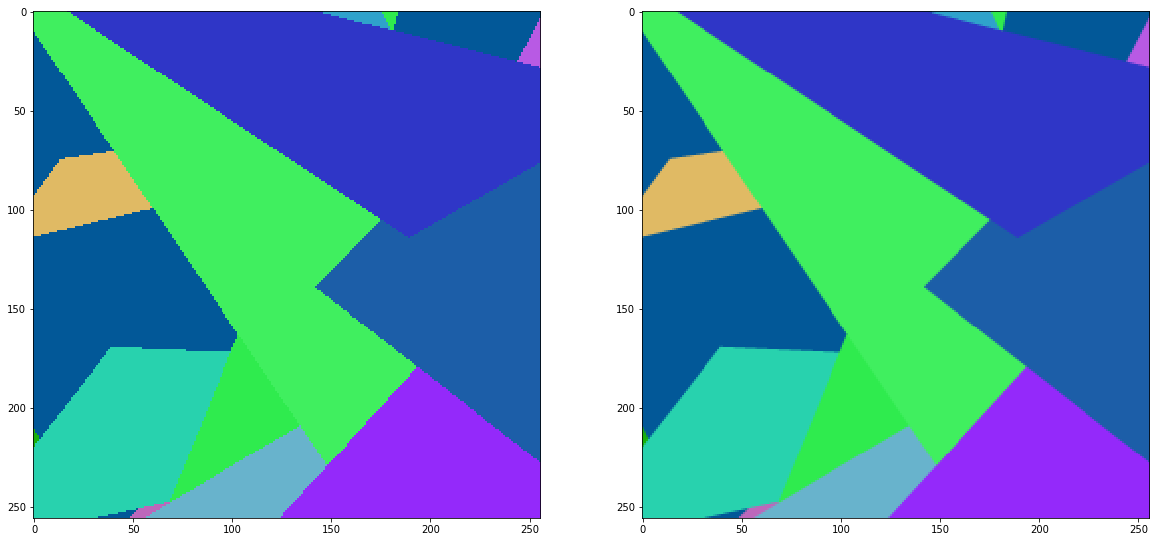

In [14]:
idx = random.randint(0, len(dev_dataset))
ori_d_t, ss_d_t = dev_dataset[idx]
ori_d_i, ss_d_i = tensor2pil(ori_d_t), tensor2pil(ss_d_t)
# print(train_dataset[0])
%matplotlib inline
plt.figure(figsize = (20,20))
plt.subplot(1,2,1)
plt.imshow(np.asarray(ori_d_i))
plt.subplot(1,2,2)
plt.imshow(np.asarray(ss_d_i))

In [14]:
print(output[0].shape)
print(ss[0].shape)

torch.Size([3, 256, 256])
torch.Size([3, 256, 256])


In [16]:
model.eval()
idx = 2
ori_t = ori[idx].cpu().detach()
# in_t_t = ori_t.unsqueeze(0).to(device)
# out_t_t, _, _ = model(in_t_t)
out_t_t = output[idx]
out_t_t = out_t_t.squeeze(0).cpu().detach()

ss_t_t = ss[idx]
ss_t_t = ss_t_t.squeeze(0).cpu().detach()

ori_t_i = tensor2pil(ori_t)
out_t_i = tensor2pil(out_t_t)

ss_t_i = tensor2pil(ss_t_t)

plt.figure(figsize = (20,20))
plt.subplot(2,2,1)
plt.imshow(np.asarray(ori_t_i))
plt.subplot(2,2,2)
plt.imshow(np.asarray(out_t_i))
plt.subplot(2,2,3)
plt.imshow(np.asarray(ss_t_i))

NameError: name 'ori' is not defined

In [41]:
# Evaluate rae
log.info('Evaluating')
batch_size = args.batch_size
model.eval()
with torch.enable_grad(), \
        tqdm(total=len(dev_loader.dataset)) as progress_bar:
    for ori_dev, ss_dev in dev_loader:
        ori_dev = ori_dev.to(device)
        ss_dev = ss_dev.to(device)
        model = model.to(device)
        model.set_input(ori_dev)
        model.reset_hidden()

        output_dev = model()
        loss, ls, lg = loss_fn_rae(output_dev, ss_dev)
        loss_val = loss.item()
#         optimizer.zero_grad()
#         loss.backward()
        # nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)
#         optimizer.step()

#         step += batch_size
        progress_bar.update(batch_size)
        progress_bar.set_postfix(Loss=loss_val)


  1%|▏         | 8/634 [00:00<00:11, 55.96it/s, Loss=0.0324]

[03.12.19 00:26:01] Evaluating


 81%|████████  | 512/634 [00:08<00:02, 58.04it/s, Loss=0.0379]


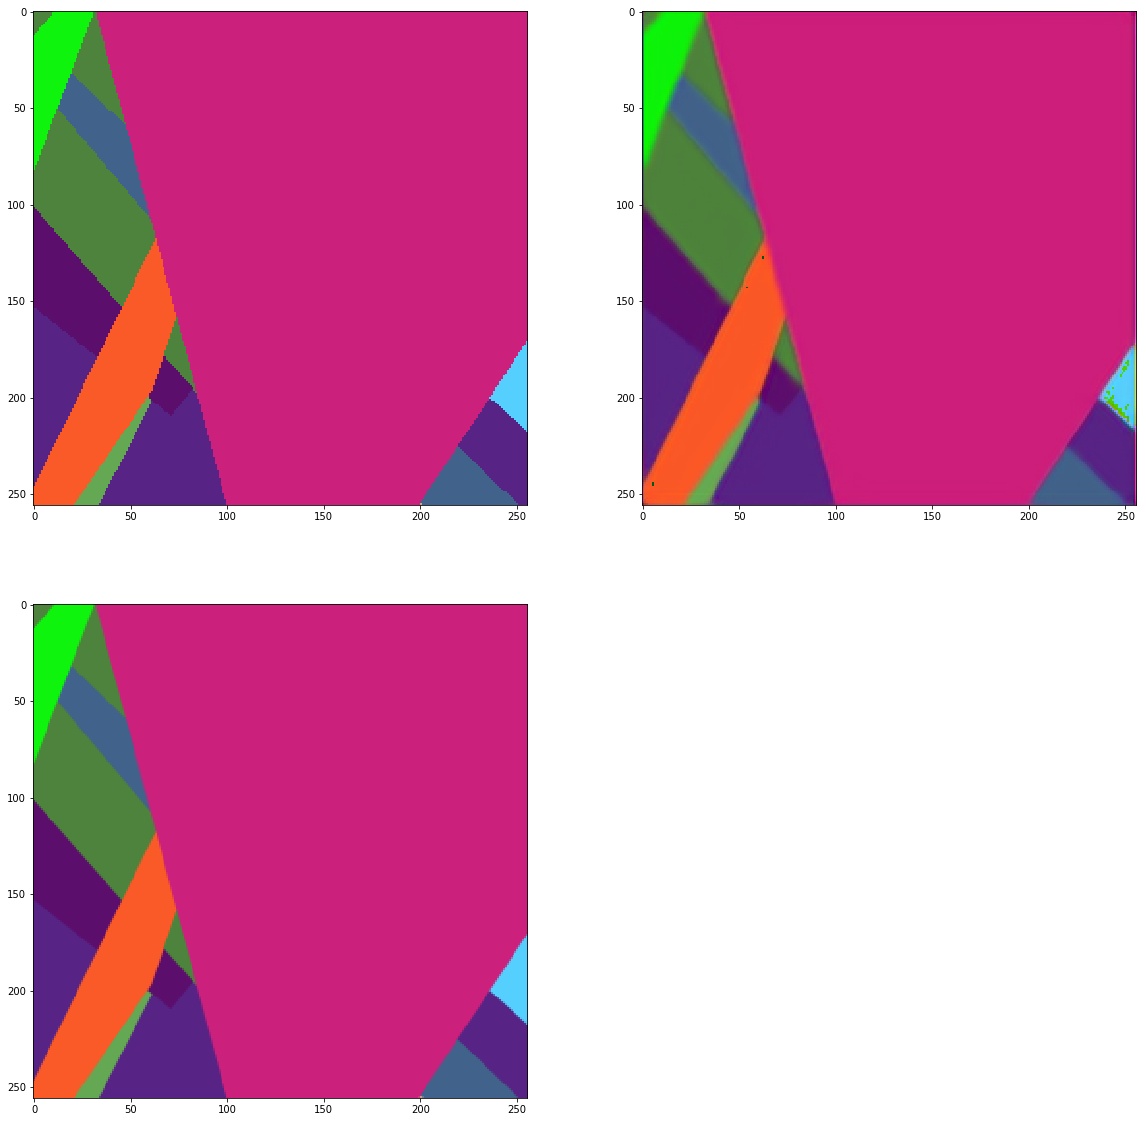

In [23]:
# model.eval()
idx = 1
ori_d = ori_dev[idx].cpu().detach()
# in_t_t = ori_t.unsqueeze(0).to(device)
# out_t_t, _, _ = model(in_t_t)
out_d_t = output_dev[idx]
out_d_t = out_d_t.squeeze(0).cpu().detach()

ss_d_t = ss_dev[idx]
ss_d_t = ss_d_t.squeeze(0).cpu().detach()

ori_d_i = tensor2pil(ori_d)
out_d_i = tensor2pil(out_d_t)
ss_d_i = tensor2pil(ss_d_t)

plt.figure(figsize = (20,20))
plt.subplot(2,2,1)
plt.imshow(np.asarray(ori_d_i))
plt.subplot(2,2,2)
plt.imshow(np.asarray(out_d_i))
plt.subplot(2,2,3)
# plt.imshow(np.asarray(ss_i))
plt.imshow(np.asarray(ss_d_i))

In [ ]:
# Try to forward the same batch several times
forward_time = 1
ori_dev_m = ori_dev

output_dev_m = ori_dev_m.to(device)
# ss_dev = ss_dev.to(device)
for _ in range(forward_time):
    model = model.to(device)
    model.set_input(output_dev_m)
    model.reset_hidden()
    output_dev_m = model()
    
out_d_m_t = output_dev_m[0].cpu().detach()
out_d_m_i = tensor2pil(out_d_m_t)
plt.figure(figsize=(50,50))
plt.imshow(np.asarray(out_d_m_i))